# **Data mining techniques for the analysis of international air traffic, focused on the United States departures between 1990 and before the covid-19 pandemic**

### **Imports and Configuration**

In [6]:
%pip install geopy
%pip install plotly
%pip install sklearn
!{sys.executable} -m pip install folium

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\sergi\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\sergi\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\sergi\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\Users\sergi\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [7]:
import pandas as pd
from geopy.geocoders import Nominatim
import numpy as np
import folium
import matplotlib.pyplot as plt
from operator import itemgetter
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from IPython.display import display, Latex

### **Import the data**

In [8]:
# importing the datasets
dep_report = pd.read_csv('data/International_Report_Departures.csv')
pass_report = pd.read_csv('data/International_Report_Passengers.csv')
iata_codes = pd.read_csv('data/IATA codes.csv')
accidentality = pd.read_csv('data/Airplane_Crashes_and_Fatalities_Since_1908.csv')
usg_apt_locations = pd.read_csv('data/usg_apt_locations.csv')
fg_apt_locations = pd.read_csv('data/fg_apt_locations.csv')

In [9]:
dep_report.columns.values

array(['data_dte', 'Year', 'Month', 'usg_apt_id', 'usg_apt', 'usg_wac',
       'fg_apt_id', 'fg_apt', 'fg_wac', 'airlineid', 'carrier',
       'carriergroup', 'type', 'Scheduled', 'Charter', 'Total'],
      dtype=object)

In [10]:
dep_report.head(5)

data_dte  Year  Month  usg_apt_id usg_apt  usg_wac  fg_apt_id fg_apt  \
0  05/01/2006  2006      5       12016     GUM        5      13162    MAJ   
1  05/01/2003  2003      5       10299     ANC        1      13856    OKO   
2  03/01/2007  2007      3       10721     BOS       13      12651    KEF   
3  12/01/2004  2004     12       11259     DAL       74      16271    YYZ   
4  05/01/2009  2009      5       13303     MIA       33      11075    CMW   

   fg_wac  airlineid carrier  carriergroup        type  Scheduled  Charter  \
0     844      20177     PFQ             1  Departures          0       10   
1     736      20007      5Y             1  Departures          0       15   
2     439      20402      GL             1  Departures          0        1   
3     936      20201     AMQ             1  Departures          0        1   
4     219      21323      5L             0  Departures          0       20   

   Total  
0     10  
1     15  
2      1  
3      1  
4     20

In [11]:
pass_report.head(5)

data_dte  Year  Month  usg_apt_id usg_apt  usg_wac  fg_apt_id fg_apt  \
0  05/01/2014  2014      5       14492     RDU       36      11032    CUN   
1  06/01/2007  2007      6       13204     MCO       33      16085    YHZ   
2  12/01/2005  2005     12       11433     DTW       43      10411    AUA   
3  04/01/2003  2003      4       13487     MSP       63      16304    ZIH   
4  12/01/2005  2005     12       12016     GUM        5      11138    CRK   

   fg_wac  airlineid carrier  carriergroup        type  Scheduled  Charter  \
0     148      19534      AM             0  Passengers          0      315   
1     951      20364      C6             0  Passengers          0      683   
2     277      20344      RD             1  Passengers          0     1010   
3     148      20204      MG             1  Passengers          0      508   
4     766      20312      TZ             1  Passengers          0       76   

   Total  
0    315  
1    683  
2   1010  
3    508  
4     76

## **Statistics**

In [12]:
def orderDataAsTimeSeries(data):
  data = data.sort_values(['Year', 'Month'], ignore_index=True)
  data.insert(0, "time", np.arange(len(data)))
  return data

In [13]:
def groupRegistersByAttributes(data, attributes):
  data = data.groupby(attributes)
  return data[['Scheduled', 'Charter', 'Total']]

In [14]:
dep_report = orderDataAsTimeSeries(dep_report)
pass_report = orderDataAsTimeSeries(pass_report)

In [15]:
# Get the data grouped by date to analize monthly and flattening the multi-index dataframes 
dep_serie = groupRegistersByAttributes(dep_report, ['Year', 'Month']).sum().reset_index()
pass_serie = groupRegistersByAttributes(pass_report, ['Year', 'Month']).sum().reset_index()
# Depreciating the start of the pandemic
dep_serie = dep_serie.iloc[0:len(dep_serie) - 1]
pass_serie = pass_serie.iloc[0:len(pass_serie) - 1]

### Mean and Standard deviation by Month and Year

In [16]:
# Data for months
dep_total_stat = dep_serie['Total'].describe()
pass_total_stat = pass_serie['Total'].describe()
print("ABOUT NUMBER OF DEPARTURES PER MONTH\n")
print(dep_total_stat.apply("{0:.3f}".format))
print("_______________________________________")
print("ABOUT NUMBER OF PASSENGERS PER MONTH\n")
print(pass_total_stat.apply("{0:.3f}".format))

ABOUT NUMBER OF DEPARTURES PER MONTH

count       362.000
mean     107735.704
std       28398.886
min       49264.000
25%       82538.000
50%      113556.500
75%      128717.500
max      165616.000
Name: Total, dtype: object
_______________________________________
ABOUT NUMBER OF PASSENGERS PER MONTH

count         362.000
mean     12533078.707
std       4030832.916
min       4672216.000
25%       9478129.500
50%      12045771.000
75%      14994987.250
max      24314837.000
Name: Total, dtype: object


In [17]:
# Data for months
dep_yearly = dep_serie.groupby('Year')['Total'].sum().describe()
pass_yearly = pass_serie.groupby('Year')['Total'].sum().describe()
print("ABOUT NUMBER OF DEPARTURES PER YEAR\n")
print(dep_yearly.apply("{0:.3f}".format))
print("_______________________________________")
print("ABOUT NUMBER OF PASSENGERS PER YEAR\n")
print(pass_yearly.apply("{0:.3f}".format))

ABOUT NUMBER OF DEPARTURES PER YEAR

count         31.000
mean     1258075.000
std       378083.571
min       268265.000
25%       963381.000
50%      1399579.000
75%      1513884.000
max      1808369.000
Name: Total, dtype: object
_______________________________________
ABOUT NUMBER OF PASSENGERS PER YEAR

count           31.000
mean     146354015.871
std       49322936.096
min       34919798.000
25%      116786215.000
50%      143711273.000
75%      170117570.000
max      244063957.000
Name: Total, dtype: object


### Linear trend

In [18]:
def displayTrendLatex(coef):
  coef = np.flip(coef)
  poly = ""
  exp = {0: '', 1: 'x'}
  for i in range(len(coef)):
    new_term = 'x^{%s}' % i if i > 1 else exp[i]
    poly = '%s{%s}%s %s' % (poly, coef[i], new_term, '' if (i == len(coef)-1 or coef[i+1] < 0) else '+')
  poly = '$%s$' % poly
  print("Trend: ")
  display(Latex(f'{poly}'))

In [19]:
def findTrend(x, y, degree):
  trend = np.polyfit(x, y, degree)
  trend_poly = np.poly1d(trend)
  displayTrendLatex(trend)
  return trend_poly

In [20]:
def estimateTotal(model, month, year):
  initYear = 1990
  monthNumber = (year - initYear)*12 + month
  return model(monthNumber)

### Monthly graph

In [21]:
def graphTotalPerMonth(df_serie, stats, title='', trend_poly=0):
  # Finding a linear trend
  x = df_serie.index
  y = df_serie['Total']
  # Graphing
  plt.rcParams["figure.figsize"] = (15, 4)
  plt.subplot(1, 2, 1)
  plt.plot(x, y)
  plt.plot(x, trend_poly(x), c='r')
  plt.legend(['amount', 'trend'])
  plt.subplot(1, 2, 2)
  plt.scatter(x, y, s=10, c='orange')
  plt.plot(x, trend_poly(x), c='r')
  plt.legend(['trend', 'amount'])
  plt.suptitle(title)

For departures

Trend: 


<IPython.core.display.Latex object>

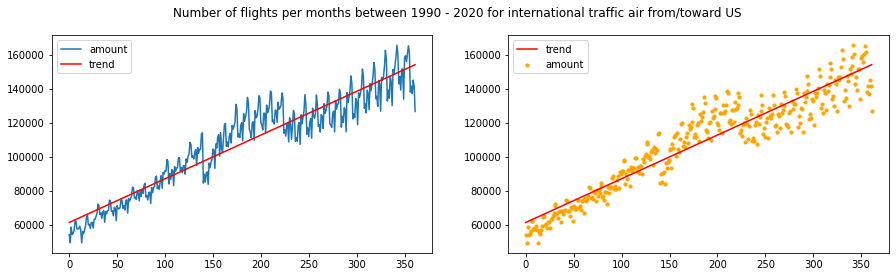

In [22]:
dep_trend_poly = findTrend(dep_serie.index, dep_serie['Total'], 1)
graphTotalPerMonth(dep_serie, dep_total_stat, 'Number of flights per months between 1990 - 2020 for international traffic air from/toward US', dep_trend_poly)

For passengers

Trend: 


<IPython.core.display.Latex object>

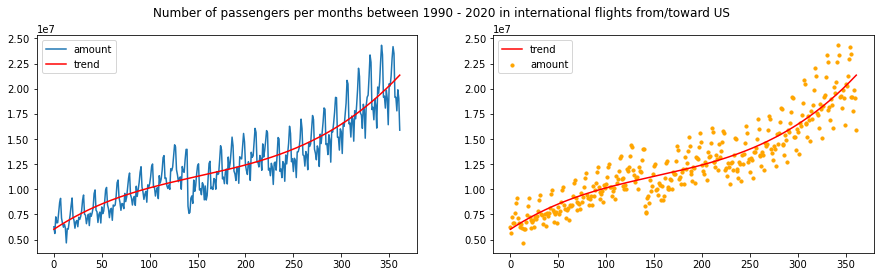

In [23]:
pass_trend_poly = findTrend(pass_serie.index, pass_serie['Total'], 3)
graphTotalPerMonth(pass_serie, pass_total_stat, 'Number of passengers per months between 1990 - 2020 in international flights from/toward US', pass_trend_poly)

#### Estimating total of flights and passengers for date

In [24]:
# Change the value for the month and year and run the cell
month = 5
year = 2022
print("Total estimated for  %s/%s:" % (month, year))
print("   flights: %s" % round(estimateTotal(dep_trend_poly, month, year)))
print("   passengers: %s" % round(estimateTotal(pass_trend_poly, month, year)))

Total estimated for  5/2022:
   flights: 161368
   passengers: 24478900


### Graphing mean and Standard deviation per Months and Years

In [25]:
# Finding statistics per months and formating the data
def statisticsPerMonths(df_serie):
  df_monthly = df_serie.copy()
  df_monthly['sum'] = df_serie.groupby('Month')['Total'].transform('sum')
  df_monthly['mean'] = df_serie.groupby('Month')['Total'].transform('mean')
  df_monthly['std'] = df_serie.groupby('Month')['Total'].transform('std')
  df_monthly['min'] = df_serie.groupby('Month')['Total'].transform('min')
  df_monthly['max'] = df_serie.groupby('Month')['Total'].transform('max')
  df_monthly = df_monthly[['Month', 'sum', 'mean', 'std', 'min', 'max']].drop_duplicates(subset=['Month'])
  df_monthly['nameMonth'] = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
  df_monthly = df_monthly.reindex(columns=['Month', 'sum', 'nameMonth','mean','std','min','max'])
  return df_monthly

In [26]:
def statisticsPerYears(df_serie):
  df_yearly = df_serie.copy()
  df_yearly['sum'] = df_serie.groupby('Year')['Total'].transform('sum')
  df_yearly = df_yearly[['Year', 'sum']].drop_duplicates(subset=['Year'])
  return df_yearly

In [27]:
def graphStatisticsPerPeriod(df_period, attribute, x_label='', y_label=''):
  not_stat_attributes = [attribute, 'nameMonth', 'sum'] if (attribute == 'Month') else [attribute]
  statistics = df_period.drop(not_stat_attributes, axis=1).columns
  colors = ['#1EBFB0', '#59F710', '#D68910', '#D666B4']
  for i in range(statistics.shape[0]):
    plt.plot(df_period[attribute], df_period[statistics[i]], c=colors[i])
  plt.legend(statistics)
  plt.xlabel(x_label, fontsize=12)
  plt.ylabel(y_label, fontsize=12)

In [28]:
def graphStatisticsPerMonths(df_monthly, y_label=''):
  graphStatisticsPerPeriod(df_monthly, attribute='Month', x_label='Month', y_label=y_label)
  plt.xticks(range(1,len(df_monthly['nameMonth']) + 1), df_monthly['nameMonth'])
  plt.grid()

In [29]:
def graphStatisticsPerYears(df_yearly, model, y_label=''):
  graphStatisticsPerPeriod(df_yearly, attribute='Year', x_label='Year', y_label=y_label)
  plt.plot(df_yearly['Year'], model(df_yearly['Year']), c='r')
  plt.legend(['departures', 'trend'])
  plt.grid()

In [30]:
pd.options.display.float_format = '{:.2f}'.format

dep_monthly = statisticsPerMonths(dep_serie)
pass_monthly = statisticsPerMonths(pass_serie)

dep_yearly = statisticsPerYears(dep_serie)
pass_yearly = statisticsPerYears(pass_serie)

Text(0.5, 0.98, 'Statistics per Month')

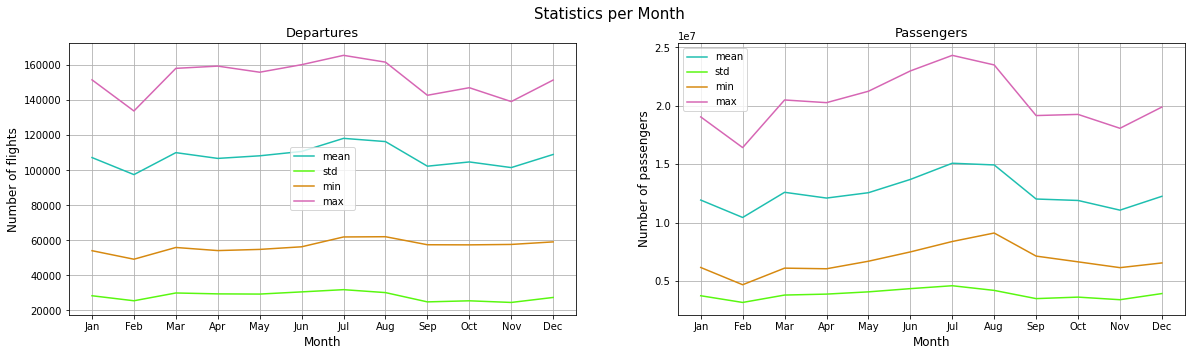

In [31]:
plt.rcParams["figure.figsize"] = (20, 5)
plt.subplot(1, 2, 1)
plt.title('Departures', fontsize=13)
graphStatisticsPerMonths(dep_monthly, y_label='Number of flights')
plt.subplot(1, 2, 2)
plt.title('Passengers', fontsize=13)
graphStatisticsPerMonths(pass_monthly, y_label='Number of passengers')
plt.suptitle("Statistics per Month", fontsize=15)

Trend: 


<IPython.core.display.Latex object>

Trend: 


<IPython.core.display.Latex object>

Text(0.5, 0.98, 'Statistics per Year')

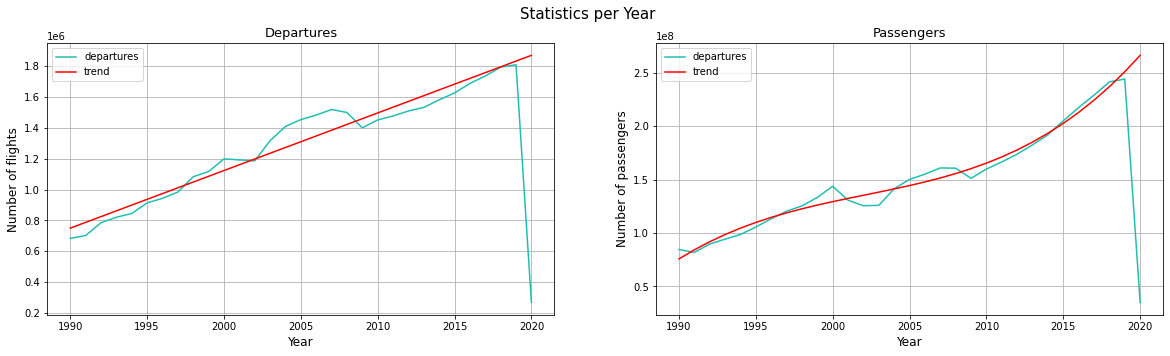

In [32]:
# Droping year 2020 because of pandemic
x_dep_year = dep_yearly['Year'].iloc[0:len(dep_yearly)-1]
y_dep_year = dep_yearly['sum'].iloc[0:len(dep_yearly)-1]
x_pass_year = pass_yearly['Year'].iloc[0:len(dep_yearly)-1]
y_pass_year = pass_yearly['sum'].iloc[0:len(dep_yearly)-1]

# Finding trends for departures and passengers
dep_trend_poly_yearly = findTrend(x_dep_year, y_dep_year, 1)
pass_trend_poly_yearly = findTrend(x_pass_year, y_pass_year, 3)

plt.rcParams["figure.figsize"] = (20, 5)
plt.subplot(1, 2, 1)
plt.title('Departures', fontsize=13)
graphStatisticsPerYears(dep_yearly, dep_trend_poly_yearly, y_label='Number of flights')
plt.subplot(1, 2, 2)
plt.title('Passengers', fontsize=13)
graphStatisticsPerYears(pass_yearly, pass_trend_poly_yearly, y_label='Number of passengers')
plt.suptitle("Statistics per Year", fontsize=15)

#### Estimating total of flights and passengers for year

In [33]:
# Change the value for the year and run the cell
year = 2015
print("Total estimated for %s:" % (year))
print("   flights: %s" % round(dep_trend_poly_yearly(year)))
print("   passengers: %s" % round(pass_trend_poly_yearly(year)))

Total estimated for 2015:
   flights: 1682953
   passengers: 202538784


## **Clustering by Months**

In [34]:
def normalizingDataValues(df_serie):
  # Normalizing variables to make clustering
  df_serie_clustering = df_serie.copy()
  # total
  df_serie_clustering['avg_year_total'] = df_serie_clustering.groupby('Year')['Total'].transform('mean')
  df_serie_clustering['std_year_total'] = df_serie_clustering.groupby('Year')['Total'].transform('std')
  # scheduled
  df_serie_clustering['avg_year_scheduled'] = df_serie_clustering.groupby('Year')['Scheduled'].transform('mean')
  df_serie_clustering['std_year_scheduled'] = df_serie_clustering.groupby('Year')['Scheduled'].transform('std')
  # charter
  df_serie_clustering['avg_year_charter'] = df_serie_clustering.groupby('Year')['Charter'].transform('mean')
  df_serie_clustering['std_year_charter'] = df_serie_clustering.groupby('Year')['Charter'].transform('std')

  normalized_total = []
  normalized_scheduled = []
  normalized_charter = []
  for i in range(len(df_serie_clustering['Year'])):
    row = df_serie_clustering.iloc[i]
    
    normalized_value_total = (row.Total - row.avg_year_total) / row.std_year_total
    normalized_total.append(normalized_value_total)

    normalized_value_scheduled = (row.Scheduled - row.avg_year_scheduled) / row.std_year_scheduled
    normalized_scheduled.append(normalized_value_scheduled)
    
    normalized_value_charter = (row.Charter - row.avg_year_charter) / row.std_year_charter
    normalized_charter.append(normalized_value_charter)

  df_serie_clustering['normalized_total'] = normalized_total
  df_serie_clustering['normalized_scheduled'] = normalized_scheduled
  df_serie_clustering['normalized_charter'] = normalized_charter
  return df_serie_clustering

In [35]:
def graphingClusters(predicted, ground_truth, X_dep, title=""):
  colors = np.array(['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff'])
  plt.rcParams["figure.figsize"] = (10, 5)

  plt.subplot(1, 2, 1)
  plt.scatter(x=X_dep['normalized_scheduled'], y=X_dep['normalized_charter'], c=colors[predicted.labels_], s=20, alpha=0.5)
  plt.xlabel('Scheduled')
  plt.ylabel('Charter')
  plt.title('graph from clustering')

  plt.subplot(1, 2, 2)
  plt.scatter(x=X_dep['normalized_scheduled'], y=X_dep['normalized_charter'], c=colors[ground_truth], s=20, alpha=0.5)
  plt.xlabel('Scheduled')
  plt.ylabel('Charter')
  plt.title('graph from ground-truth')

  plt.suptitle('Clustering with normalized values for ' + title, fontsize=15)

### for departures

In [36]:
dep_serie_clustering = normalizingDataValues(dep_serie)
X_dep = dep_serie_clustering.loc[:, ['normalized_scheduled', 'normalized_charter']]

ground_truth_dep = dep_serie['Month'].values - 1

In [37]:
# Adjusting the model
predicted_dep = AgglomerativeClustering(n_clusters=12, affinity='euclidean')
predicted_dep.fit(X_dep)

AgglomerativeClustering(n_clusters=12)

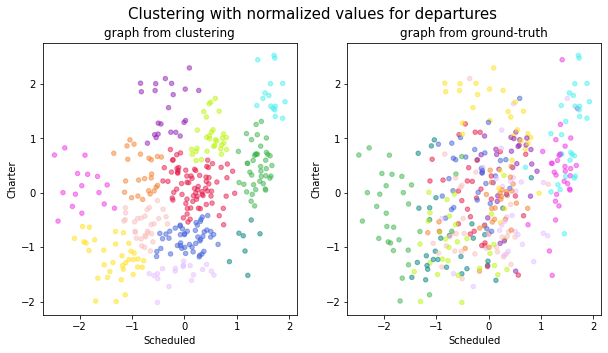

In [38]:
# Graphing the clusters fitted
graphingClusters(predicted_dep, ground_truth_dep, X_dep, 'departures')

Performance of the clustering

In [39]:
# Adjusted rand score > 0 -> good
print('Adjusted rand score: ', metrics.adjusted_rand_score(ground_truth_dep, predicted_dep.labels_))
# Adjusted mutual info score >> 0 -> good
print('Adjusted mutual info score: ', metrics.adjusted_mutual_info_score(ground_truth_dep, predicted_dep.labels_))

Adjusted rand score:  0.18988614085911187
Adjusted mutual info score:  0.35623963787551477


### for passengers

In [40]:
pass_serie_clustering = normalizingDataValues(pass_serie)
X_pass = pass_serie_clustering.loc[:, ['normalized_scheduled', 'normalized_charter']]

ground_truth_pass = pass_serie['Month'].values - 1

In [41]:
# Adjusting the model
predicted_pass = AgglomerativeClustering(n_clusters=12, affinity='euclidean')
predicted_pass.fit(X_pass)

AgglomerativeClustering(n_clusters=12)

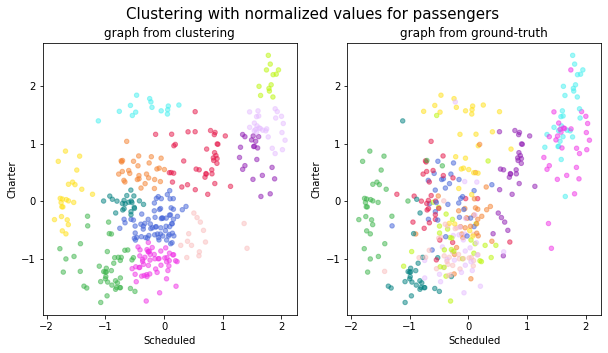

In [42]:
# Graphing the clusters fitted
graphingClusters(predicted_pass, ground_truth_pass, X_pass, 'passengers')

Performance of the clustering

In [43]:
# Adjusted rand score > 0 -> good
print('Adjusted rand score: ', metrics.adjusted_rand_score(ground_truth_pass, predicted_pass.labels_))
# Adjusted mutual info score >> 0 -> good
print('Adjusted mutual info score: ', metrics.adjusted_mutual_info_score(ground_truth_pass, predicted_pass.labels_))

Adjusted rand score:  0.2866069576509507
Adjusted mutual info score:  0.474018952393015


### Observation
There is a good relation between the number of departures and the month to make clusters. It's not perfect but it can be seen easily.

## **Map**

In [44]:
# counting the airport departures and group them in a single dataframe
grouped_usg = dep_report.groupby(['usg_apt']).size().reset_index(name='counts')
ordered_cities_usg = grouped_usg.sort_values(by='counts', ascending=False)

grouped_fg = dep_report.groupby(['fg_apt']).size().reset_index(name='counts')
ordered_cities_fg = grouped_fg.sort_values(by='counts', ascending=False)

In [45]:
usg_codigosIATA = dep_report.groupby(['usg_apt']).size().reset_index(name='counts').usg_apt.unique()
fg_codigosIATA = dep_report.groupby(['fg_apt']).size().reset_index(name='counts').fg_apt.unique()

### Section used to extract the geographical information just the first time to preprocess

In [46]:
def getAirportNameFromIATACode(iataCode):
  dataRow = iata_codes.loc[iata_codes['iataCode'] == iataCode].reset_index()
  if(dataRow.empty == False):
    airportName = dataRow['Airport name'][0] +' '+ dataRow['Location'][0] +' '+ dataRow['Country'][0]
    return airportName

In [47]:
def calc_airport_location(iataCode):
  geolocalizador = Nominatim(user_agent="a@uninorte.edu.co")
  airportName = getAirportNameFromIATACode(iataCode)
  if(airportName):
    location = geolocalizador.geocode(airportName, timeout=15)
    return location

In [48]:
def getAirportFullInformation(iataCode):
  location = calc_airport_location(iataCode)
  dataRow = iata_codes.loc[iata_codes['iataCode'] == iataCode].reset_index()
  if(location and dataRow.empty == False):
    airport_name = dataRow['Airport name'][0]
    iata_code = dataRow['iataCode'][0]
    region = dataRow['Location'][0]
    country = dataRow['Country'][0]
    info = (location.latitude,location.longitude, iata_code, airport_name, region, country)
    return info

In [49]:
def getAirportsListFullInformation(iataCodes, parameter):
  infoList = []
  dep_info = dep_report.groupby([parameter]).sum().reset_index()
  pass_info = pass_report.groupby([parameter]).sum().reset_index()
  for i in range(len(iataCodes)):
    info = getAirportFullInformation(iataCodes[i])
    dep_amount = dep_info[iataCodes[i] == dep_info[parameter]]['Total'].item()
    pass_amount = pass_info[iataCodes[i] == pass_info[parameter]]['Total']
    pass_amount = pass_amount.item() if (len(pass_amount) > 0) else 'No info'
    if(info):
      info = (*info, dep_amount, pass_amount)
      infoList.append(info)
  return infoList

In [50]:
# usg_apt_locations = getAirportsListFullInformation(usg_codigosIATA, 'usg_apt')
# fg_apt_locations = getAirportsListFullInformation(fg_codigosIATA, 'fg_apt')

In [51]:
# # Turning the data into a CSV file
# usg = pd.DataFrame(usg_apt_locations, columns=['longitud', 'latitud', 'iata_code', 'airport_name', 'region', 'country', 'amount'])
# fg = pd.DataFrame(fg_apt_locations, columns=['longitud', 'latitud', 'iata_code', 'airport_name', 'region', 'country', 'amount'])

# usg.to_csv('usg_apt_locations.csv', index=False)
# fg.to_csv('fg_apt_locations.csv', index=False)

### Utils for plotting the departures information

In [52]:
# get the arrays for some variables for a later plotting
def get_airports_info(locations):
  latitud = locations['latitud']
  longitud = locations['longitud']
  iata = locations['iata_code']
  airport_name = locations['airport_name']
  region = locations['region']
  country = locations['country']
  dep_amount = locations['dep_amount']
  pass_amount = locations['pass_amount']
  mediaLat = sum(latitud)/len(latitud)
  mediaLon = sum(longitud)/len(longitud)
  return { "longitud": longitud,
          "latitud": latitud,
          "iata_code": iata,
          "airport_name": airport_name,
          "region": region,
          "country": country,
          "dep_amount": dep_amount,
          "pass_amount": pass_amount,
          "mediaLat": mediaLat,
          "mediaLon": mediaLon }

In [53]:
def format_info(iata, airport_name, region, country, dep_amount, pass_amount):
  info = ("<b>IATA:</b> %s\n"
    "<b>Airport name:</b> %s\n"
    "<b>Location:</b> %s\n"
    "<b>Country:</b> %s\n"
    "<b>Number of flights:</b> %s\n"
    "<b>Number of passengers:</b> %s\n") % (iata, airport_name, region, country, dep_amount, pass_amount)
  return info

In [54]:
# placing each identified airport in the map
def plot_map(airports_info, color='#3388ff', with_weight=True):
  longitud, latitud, iata, airport_name, region, country, mediaLat, mediaLon, dep_amount, pass_amount = itemgetter('longitud', 'latitud', 'iata_code', 'airport_name', 'region', 'country', 'mediaLat', 'mediaLon', 'dep_amount', 'pass_amount')(airports_info)
  map = folium.Map(location=[mediaLat,mediaLon], zoom_start=2, control_scale= True)
  longitud = longitud.values
  latitud = latitud.values
  iata = iata.values
  airport_name = airport_name.values
  region = region.values
  country = country.values
  dep_amount = dep_amount.values
  pass_amount = pass_amount.values
  for i in range(len(latitud)):
    info = format_info(iata[i], airport_name[i], region[i], country[i], dep_amount[i], pass_amount[i])
    opacity = 0.3 + 0.7*(dep_amount[i]/max(dep_amount))
    radius = 50000 + (80000*(dep_amount[i]/max(dep_amount)))
    folium.Circle([longitud[i], latitud[i]], radius=radius, popup=info, color=color, opacity=opacity, fill=True).add_to(map)
  return map

### US airports and information

In [55]:
map_usg_apt = plot_map(get_airports_info(usg_apt_locations), "blue")
map_usg_apt

### Foreign airports and information

In [56]:
map_fg_apt = plot_map(get_airports_info(fg_apt_locations), "red")
map_fg_apt

## **Airports with more departures**

In [57]:
# counting the airport departures and group them in a single dataframe
grouped_usg = dep_report.copy()
grouped_usg['counts'] = grouped_usg.groupby(['usg_apt'])['Total'].transform('sum')
grouped_usg = grouped_usg.drop_duplicates(subset=['usg_apt'])
ordered_cities_usg = grouped_usg.sort_values(by=['counts'], ascending=False)

grouped_fg = dep_report.copy()
grouped_fg['counts'] = grouped_fg.groupby(['fg_apt'])['Total'].transform('sum')
grouped_fg = grouped_fg.drop_duplicates(subset=['fg_apt'])
ordered_cities_fg = grouped_fg.sort_values(by=['counts'], ascending=False)

In [58]:
# parameter can be takeoff or landing
def first_n_cities(n, parameter, work_wirh_states=False):
  attribute = 1 if (work_wirh_states) else 0
  if (parameter == "takeoff"):
    ordered_cities = ordered_cities_usg.copy()
    field = "usg_apt"
  else:
    ordered_cities = ordered_cities_fg.copy()
    field = "fg_apt"
  names = []
  iataCode = ordered_cities[field].values
  # Find cities for IATA codes
  for i in range(len(iataCode)):
    try:
      tmp_reg = iata_codes[iata_codes.iataCode == iataCode[i]]
      tmp_reg = tmp_reg['Location'].item().split(",")[attribute]
    except:
      tmp_reg = 'NA'
    names.append(tmp_reg)

  ordered_cities['city'] = names
  ordered_cities['counts'] = ordered_cities.groupby('city')['counts'].transform('sum')
  ordered_cities = ordered_cities.drop_duplicates(subset=['city'])
  ordered_cities = ordered_cities.sort_values(by=['counts'], ascending=False)

  first_n = ordered_cities.head(n=n)
  names = first_n['city']
  return {
    "ordered": ordered_cities,
    "cities": list(map(lambda x: x.replace(" ", "\n"), names)),
    "first_n": first_n
  }

In [59]:
#in case map doesn't work, delete, before run this cell, the map object with >> del map
def bar_most_traffic(n, parameter, color='orange', work_wirh_states=False):
  first_cities = first_n_cities(n, parameter, work_wirh_states)
  kind = 'US' if parameter == 'takeoff' else "Foreign"
  plt.figure(figsize=(14, 5))
  plt.bar(first_cities["cities"], first_cities["first_n"]['counts'], width=0.8, color=color)
  plt.ylabel('Airports %s Number' % kind, fontsize=15)
  plt.xlabel('Airport Code', fontsize=15)
  plt.title('%s Cities for Greater Traffic ' % kind, fontsize=25)
  plt.rcParams.update({'font.size': 10})
  plt.show()

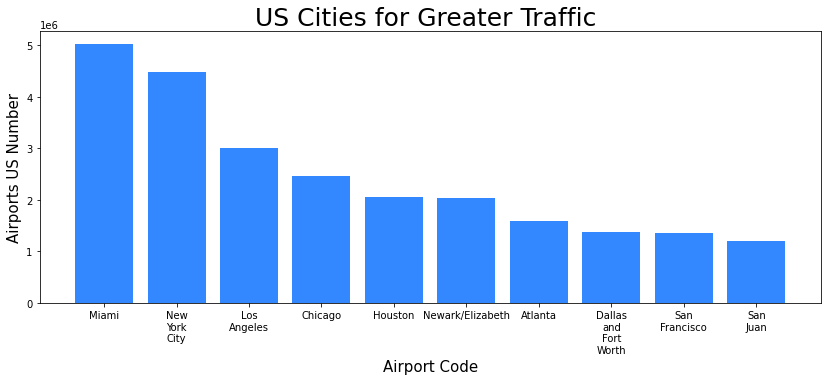

In [60]:
# Change the variable 'n' to get the n first cities with more air traffic in US
# Change the parameter 'work_wirh_states' to True to see the graph by states
n = 10
bar_most_traffic(n, 'takeoff', "#3388ff", work_wirh_states=False)

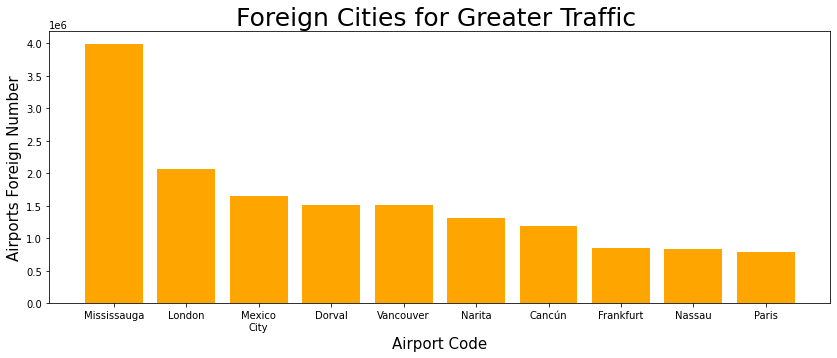

In [61]:
# Change the variable 'n' to get the n first cities with more air traffic out of US
n = 10
bar_most_traffic(n, 'landing', "orange")

## **Departures by aiports**

### All the places an US airport sends flights to, according with its IATA code

In [62]:
#Change the 'aero_salida' variable for the one that you want to know about
aero_salida = 'ATL'
departure_airports = dep_report[dep_report['usg_apt'] == aero_salida]
aiports_to_print = []
for i in range(len(departure_airports)):
  aiports_to_print.append(departure_airports.iloc[i]['fg_apt'])

df_to_print = fg_apt_locations[fg_apt_locations['iata_code'].isin(aiports_to_print)]

m = plot_map(get_airports_info(df_to_print), "red")

local_point = usg_apt_locations[usg_apt_locations['iata_code'] == aero_salida]
info = format_info(local_point.iata_code.item(), local_point.airport_name.item(), local_point.region.item(), local_point.country.item(), local_point.dep_amount.item(), local_point.pass_amount.item())
folium.Circle([local_point.longitud.item(), local_point.latitud.item()], popup=info, radius=100000, color='orange', fill=True).add_to(m)
m

### All the places a foreign airport sends flights to, according with its IATA code

In [63]:
#Change the 'aero' variable for the one that you want to know about
aero = 'CUN'
departure_airports = dep_report[dep_report['fg_apt'] == aero]
departure_airports
aiports_to_print = []
for i in range(len(departure_airports)):
  aiports_to_print.append(departure_airports.iloc[i]['usg_apt'])

df_to_print = usg_apt_locations[usg_apt_locations['iata_code'].isin(aiports_to_print)]
m = plot_map(get_airports_info(df_to_print), "blue")

local_point = fg_apt_locations[fg_apt_locations['iata_code'] == aero]
info = format_info(local_point.iata_code.item(), local_point.airport_name.item(), local_point.region.item(), local_point.country.item(), local_point.dep_amount.item(), local_point.pass_amount.item())
folium.Circle([local_point.longitud.item(), local_point.latitud.item()], popup=info, radius=100000, color='orange', fill=True).add_to(m)
m

## **Accidentality**

In [64]:
#As the dataset has several NaN values in some columns, we delete them
del accidentality["Flight #"]
del accidentality["Route"]
del accidentality["cn/In"]
del accidentality["Registration"]
del accidentality["Time"]
del accidentality["Ground"]

#Fix the date format
accidentality["Date"] = pd.to_datetime(accidentality["Date"])

#Add a new column with just the year of the accident for analysis
accidentality['Year'] = pd.DatetimeIndex(accidentality['Date']).year

#Add a new column for the accident survivals
accidentality['Survived'] = accidentality['Aboard'] - accidentality['Fatalities']
accidentality.Survived = np.where(accidentality.Survived < 0, 0, accidentality.Survived)

#Add a new column for the accident survivals Rates
accidentality['Survival Rate'] = 100 * (accidentality['Aboard'] - accidentality['Fatalities'])/ accidentality['Aboard']

100 * accidentality.isnull().sum()/len(accidentality)

Date            0.00
Location        0.38
Operator        0.34
Type            0.51
Aboard          0.42
Fatalities      0.23
Summary         7.40
Year            0.00
Survived        0.42
Survival Rate   0.46
dtype: float64

In [65]:
#Accident with most people aboard
maxAcc = accidentality['Aboard'].max()
accidentality.loc[accidentality['Aboard'] == maxAcc]

Date                  Location                          Operator  \
2963 1977-03-27  Tenerife, Canary Islands  Pan American World Airways / KLM   

                                      Type  Aboard  Fatalities  \
2963  Boeing B-747-121 / Boeing B-747-206B  644.00      583.00   

                                                Summary  Year  Survived  \
2963  Both aircraft were diverted to Tenerife becaus...  1977     61.00   

      Survival Rate  
2963           9.47

In [66]:
#Accident with most survivals
maxSurv = accidentality['Survived'].max()
accidentality.loc[accidentality['Survived'] == maxSurv]

Date      Location            Operator          Type  Aboard  \
4645 1999-07-23  Tokyo, Japan  All Nippon Airways  Boeing B-747  517.00   

      Fatalities                                            Summary  Year  \
4645        1.00  Two minutes after taking off from Haneda Airpo...  1999   

      Survived  Survival Rate  
4645    516.00          99.81

In [67]:
#Accident with no fatallities
maxSurvRate = accidentality['Survival Rate'].max()
accidentality.loc[accidentality['Survival Rate'] == maxSurvRate]

Date                                      Location  \
108  1926-10-21                               English Channel   
387  1936-03-05                            Near Tengya, China   
889  1947-10-08                           Near El Paso, Texas   
897  1947-11-11                            Gallup, New Mexico   
1265 1953-05-25                        Amsterdam, Netherlands   
1359 1955-01-19                              Des Moines, Iowa   
1440 1956-09-09                        Bartlesville, Oklahoma   
1443 1956-10-16                          Over the PacifiOcean   
1610 1959-06-30         Ishikawa City, Ryukyu Island, Okinawa   
1837 1963-02-28                         Boston, Massachusetts   
1868 1963-08-21                       Near Leningrad , Russia   
1885 1963-12-17                       Los Angeles, California   
1927 1964-07-16                            Richmond, Virginia   
1982 1965-06-28                     San Francisco, California   
1983 1965-07-01                         Kansas City, Missouri   
2066 1966-08-17                   Near Da Nang, South Vietnam   
2247 1968-08-28                             Lopez, Washington   
2266 1968-11-22                     San Francisco, California   
2359 1969-12-22                    Near San Diego, California   
2486 1971-07-30                     San Francisco, California   
2590 1972-09-24                        Sacramento, California   
2835 1975-08-07                              Denver, Colorado   
3182 1979-11-15                        Near Chicago, Illinois   
3341 1982-06-24                   Mount Galunggung, Indonesia   
3366 1982-07-23                           Castaic, California   
3417 1983-05-05          En route Miami, FL - Nassau, Bahamas   
3428 1983-07-23                       Gimli, Manitoba, Canada   
3470 1984-02-28               JFK Airport, New York, New York   
3541 1985-02-19        300 nm NW of San Francisco, California   
3549 1985-04-16                        Las Cruces, New Mexico   
3767 1988-05-24                        New Orleans, Louisiana   
3927 1990-03-01                            Near Meerut, India   
3950 1990-06-10                          Oxfordshire, England   
4068 1991-12-27                             Stockholm, Sweden   
4117 1992-07-30               JFK Airport, New York, New York   
4171 1993-03-31                             Anchorage, Alaska   
4199 1993-08-18  Leeward Point Airfield, Guantanamo Bay, Cuba   
4231 1994-03-02                            New York, New York   
4242 1994-03-23             Near Fayetteville, North Carolina   
4273 1994-08-10                            Cheju, South Korea   
4339 1995-06-08                              Atlanta, Georgia   
4543 1998-02-03                  Near Cavalese, Trento, Italy   
4553 1998-03-22                          Bacolod, Philippines   
4594 1998-10-21                              Yerevan, Armenia   
4701 2000-03-05                          Burbank, Calilfornia   
4748 2000-10-06                               Reynosa, Mexico   
4797 2001-08-24                              Terceira, Azores   
4875 2002-07-27                                 Lviv, Ukraine   
5057 2005-08-02                               Toronto, Canada   
5074 2005-12-08                             Chicago, Illinois   
5134 2007-01-25                                   Pau, France   
5178 2007-11-08                               Khartoum, Sudan   
5186 2008-01-17                               London, England   
5197 2008-04-15                                   Goma, Congo   
5217 2008-07-07                         Near Bogota, Colombia   
5245 2009-01-15                            New York, New York   

                                               Operator  \
108                                    Imperial Airways   
387                 China National Aviation Corporation   
889                                   American Airlines   
897                                   American Airlines   
1265      

In [68]:
#Accident with most fatalities
maxFat = accidentality['Fatalities'].max()
accidentality.loc[accidentality['Fatalities'] == maxFat]

Date                  Location                          Operator  \
2963 1977-03-27  Tenerife, Canary Islands  Pan American World Airways / KLM   

                                      Type  Aboard  Fatalities  \
2963  Boeing B-747-121 / Boeing B-747-206B  644.00      583.00   

                                                Summary  Year  Survived  \
2963  Both aircraft were diverted to Tenerife becaus...  1977     61.00   

      Survival Rate  
2963           9.47

### **Airplanes Crashes for year**

In [69]:
years = accidentality.groupby('Year').size().reset_index(name='Counts')

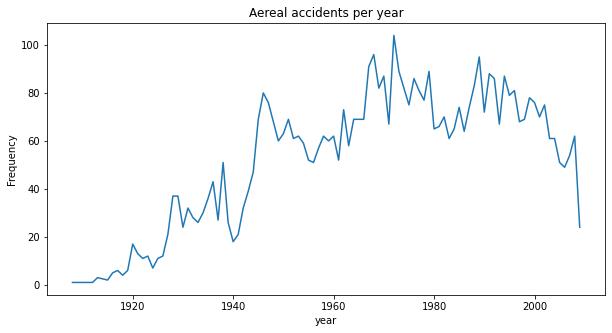

In [70]:
plt.plot(years['Year'], years['Counts'])
plt.title('Aereal accidents per year')
plt.xlabel('year')
plt.ylabel('Frequency')
plt.show()

In [71]:
#The year with most crashes was 1972 with 104 crashes
max_year = years['Counts'].max()
years.loc[years['Counts'] == max_year]

Year  Counts
60  1972     104

In [72]:
pd.set_option('display.max_rows', None)
accidentality

Date                                           Location  \
0    1908-09-17                                Fort Myer, Virginia   
1    1912-07-12                            AtlantiCity, New Jersey   
2    1913-08-06                 Victoria, British Columbia, Canada   
3    1913-09-09                                 Over the North Sea   
4    1913-10-17                         Near Johannisthal, Germany   
5    1915-03-05                                    Tienen, Belgium   
6    1915-09-03                              Off Cuxhaven, Germany   
7    1916-07-28                              Near Jambol, Bulgeria   
8    1916-09-24                                Billericay, England   
9    1916-10-01                               Potters Bar, England   
10   1916-11-21                                     Mainz, Germany   
11   1916-11-28                       Off West Hartlepool, England   
12   1917-03-04                                 Near Gent, Belgium   
13   1917-03-30                               Off Northern Germany   
14   1917-05-14                       Near Texel Island, North Sea   
15   1917-06-14                     Off Vlieland Island, North Sea   
16   1917-08-21                                Off western Denmark   
17   1917-10-20                             Near Luneville, France   
18   1918-04-07                             Over the Mediterranean   
19   1918-05-10                      Off Helgoland Island, Germany   
20   1918-08-11                          Ameland Island, North Sea   
21   1918-12-16                              Elizabeth, New Jersey   
22   1919-05-25                                    Cleveland, Ohio   
23   1919-07-19                              Dix Run, Pennsylvania   
24   1919-10-02                                 Newcastle, England   
25   1919-10-14                             Cantonsville, Maryland   
26   1919-10-20                                    English Channel   
27   1919-10-30                            Long Valley, New Jersey   
28   1920-03-10                                 New Paris, Indiana   
29   1920-03-30                                 Newark, New Jersey   
30   1920-04-10                                 Newark, New Jersey   
31   1920-04-11                           Heller Field, New Jersey   
32   1920-05-12                                    Oskaloosa, Iowa   
33   1920-06-06                                    Cleveland, Ohio   
34   1920-08-16                                   Bedford, England   
35   1920-08-16                             College Park, Maryland   
36   1920-09-01                             Morristown, New Jersey   
37   1920-09-15                                  Pemberville, Ohio   
38   1920-09-27                          Hillersburg, Pennsylvania   
39   1920-10-02                           Off Port Vendres, France   
40   1920-10-05                                    Valencia, Spain   
41   1920-10-15                                  Batavia, Illinois   
42   1920-11-07                                Tie Siding, Wyoming   
43   1920-12-14                               Cricklewood, England   
44   1920-12-24                                   Barcelona, Spain   
45   1921-02-03                                Mendotta, Minnisota   
46   1921-02-09                               La Crosse, Wisconsin   
47   1921-02-15                                      Off Gibraltar   
48   1921-02-22                                       Elko, Nevada   
49   1921-04-06                              Point Cook, Australia   
50   1921-04-21                                  Mitchel Field, NY   
51   1921-04-29                                    Cleveland, Ohio   
52   1921-05-17                              Rock Springs, Wyoming   
53   1921-07-16                          San Francisco, California   
54   1921-08-14                                   Toulouse, France   
55   1921-08-24                              River Humber, England   
56   1921-09-06      

### **Average Survival Rate per year**

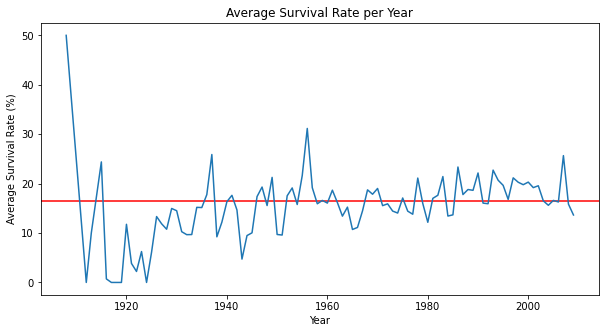

In [73]:
yearly_survival = accidentality[["Year","Survival Rate"]].groupby(accidentality["Year"]).agg('mean')
data_mean = accidentality["Survival Rate"].mean()
plt.ylabel("Average Survival Rate (%)")
plt.xlabel("Year")
plt.title("Average Survival Rate per Year")
plt.axhline(y=data_mean, color='r', linestyle='-')
plt.plot(yearly_survival['Year'], yearly_survival['Survival Rate'])
plt.show()

### **Airplanes types with more accidentality**

In [74]:
airplanes = accidentality.groupby('Type').size().reset_index(name='Counts')
ordered_airplanes = airplanes.sort_values(by='Counts', ascending=False)

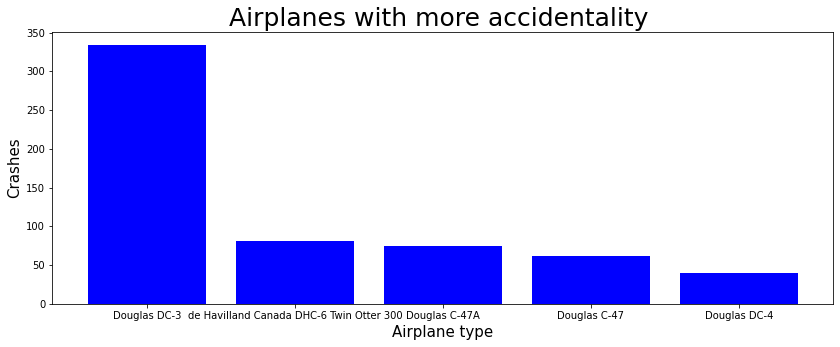

In [75]:
plt.figure(figsize=(14, 5))
plt.bar(ordered_airplanes['Type'].head(), ordered_airplanes['Counts'].head(), width=0.8, color='blue')
plt.ylabel('Crashes', fontsize=15)
plt.xlabel('Airplane type', fontsize=15)
plt.title('Airplanes with more accidentality ', fontsize=25)
plt.rcParams.update({'font.size': 10})
plt.show()